# Exploiting all the methods tried so far

In [1]:
#utils
import emoji, re, string, time, os
from utils import get_test_metrics
from utils import preprocess
from utils import get_user_features, get_top_users
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle
import math

#nlp
import nltk
from nltk.corpus import stopwords
import spacy
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
def optimal_threshold(prob,y):
    best_thresold = 0
    best_score = 0
    
    for i in range(100):
        threshold = i/100
        y_pred = [1 if p >= threshold else 0 for p in prob]
        score = metrics.accuracy_score(y,y_pred)
        
        if score > best_score:
            #print(score)
            best_thresold = threshold
            best_score = score
            
    return best_thresold

# optimal mlp for tfidf
def get_mlp():
    clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-3, verbose = False, early_stopping = True, 
                   n_iter_no_change = 10, max_iter = 200,
                   hidden_layer_sizes = (100,), alpha = 0.0067, 
                   learning_rate_init = .00026, batch_size = 50)
    return clf

# tunning hyperparameters mlp
n_iter = 10
def random_layers():
    '''
    Create a tuple random of hidden_layer_sizes. 
    '''
    n_layers = np.random.randint(1,4)
    layers_list = []
    for i in range(n_layers):            
        hidden_neurons = np.random.randint(1,15)*25
        layers_list.append(hidden_neurons)
    layers_tuple = tuple(layers_list)
    return layers_tuple

def random_search_mlp(X_train,y_train,n_iter=10):
    
    # hyperparams to optimize
    hidden_layers = []
    alphas = []
    batch_sizes = []
    learning_rate_inits = []
    # sample
    np.random.seed(0)
    for i in range(n_iter):   
        hl = random_layers()
        #print(hl,end = '; ')
        hidden_layers.append(hl)
        ap = 10**np.random.uniform(-6,-2)
        #print(ap, end = '; ')
        alphas.append(ap)
        learning = 10**np.random.uniform(-4,-1)
        #print(learning, end = '; ')
        learning_rate_inits.append(learning)
        batch = np.random.randint(1,7)*50 #math.floor(10**np.random.uniform(1.5,2.6)) #np.random.randint(2,30)*10
        #print(batch)
        batch_sizes.append(batch)

    # tunning
    X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    best_score = 0
    i = 0
    for hl,bs,al,lri in zip(hidden_layers,batch_sizes,alphas,learning_rate_inits):
        
        clf = optimized_mlp(hl,bs,al,lri)

        print(i, end= ' ')
        i+=1
        print()
        print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))    
        clf.fit(X_train_v, y_train_v)
        y_pred = clf.predict(X_val)        
        y_prob = clf.predict_proba(X_val)[:,1]
        
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_prob, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        print('AUC: {a:.3f}'.format(a=roc_auc))       
        if roc_auc > best_score:
            best_score = roc_auc
            best_params = (hl,bs,al,lri)

        #print('validation rmse: {a:.3f}'.format(a=rmse))


    hl,bs,al,lri = best_params
    print()
    print('--------------------')
    print('BEST PARAMETERS (validation AUC = {a:.3f})'.format(a=best_score))
    print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))
    print('--------------------')
    return hl,bs,al,lri

def optimized_mlp(hl,bs,al,lri):
    clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = False, early_stopping = True, 
                   n_iter_no_change = 10, max_iter = 100,
                   hidden_layer_sizes = hl, alpha = al, 
                   learning_rate_init = lri, batch_size = bs)
    return clf

def train_test(clf,X_train,X_test,y_train,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]
    test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)
    return test_metrics
    


In [114]:
# data correction
# df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
# df['misinformation'] = [mis if sha > 1 else -1 for mis,sha in zip(df['misinformation'], df['shares'])]
# df.head()
# df.to_csv('data/2018/fakeWhatsApp.BR_2018.csv',index=False)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dataset expansion

In [117]:
# messages
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df_texts = pd.read_csv('data/2018/high_quality_labels/fakeWhatsApp.BR_2018_preprocessed_texts.csv')
df = pd.concat([df, df_texts], axis=1)
df.drop(columns=['Unnamed: 0'],inplace=True)
corpus = list(df[df['midia']==0]['preprocessed_text_lemma'].unique())
print('size total data:',len(df))

print('manually labelled messages:',len(df[df['shares']>1]))

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


size total data: 282601
manually labelled messages: 20872


In [103]:
df_labelled = df[df['shares']>1].drop_duplicates(subset=['text'])
print('unique manually labelled messages',len(df_labelled))

unique manually labelled messages 5284


In [104]:
#9.19*(len(df)/5000)/60
#df = df[0:5000]

In [105]:
hidden_midia = '<Arquivo de mídia oculto>'
threshold = 0.8

labelled_texts = list(df_labelled['text'])
labels = list(df_labelled['misinformation'])
non_labelled_texts = list(df['text'])

# vectorize non-labelled and labelled
non_labelled_tfidf = vectorizer.fit_transform(non_labelled_texts)  
tfidf_labels = vectorizer.transform(labelled_texts)
non_labelled_tfidf_list = list(non_labelled_tfidf)

best_msgs = []
best_labels = []
best_dists = []

cen = int(len(non_labelled_tfidf_list)/10)

start_loop = time.time()
start_time = time.time()
for i,msg in enumerate(non_labelled_tfidf_list):
    
    if(i%cen==0):
        ith = int(i/cen + 1)
        print(str(ith) + '/10')
        end_time = time.time()
        print('time ellapsed since last 10%:',end_time-start_time)
        start_time = time.time()
        
    if non_labelled_texts[i] == hidden_midia:
        best_labels.append(-1)
        best_msgs.append(None)
        best_dists.append(0) 
        continue
        
    cosine_similarities = linear_kernel(msg, tfidf_labels).flatten()
    best_match_ix = np.argmax(cosine_similarities)
    sim = np.max(cosine_similarities)
    
    if sim < threshold:
        best_labels.append(-1)
        best_msgs.append(None)
        
    else:
        best_labels.append(labels[best_match_ix])
        best_msgs.append(labelled_texts[best_match_ix])
        
    best_dists.append(sim) 

end_loop = time.time()
print('time ellapsed:',end_loop-start_loop)
    
df['BEST_MATCH'] = best_msgs
df['BEST_SIM'] = best_dists
df['BEST_LABEL'] = best_labels

df[['text','BEST_MATCH','BEST_LABEL']]

1/10
time ellapsed since last 10%: 0.0004227161407470703
2/10
time ellapsed since last 10%: 76.19063949584961
3/10
time ellapsed since last 10%: 75.640545129776
4/10
time ellapsed since last 10%: 69.89740300178528
5/10
time ellapsed since last 10%: 69.95258045196533
6/10
time ellapsed since last 10%: 77.47658371925354
7/10
time ellapsed since last 10%: 87.12387299537659
8/10
time ellapsed since last 10%: 83.8605146408081
9/10
time ellapsed since last 10%: 89.45088863372803
10/10
time ellapsed since last 10%: 91.02450704574585
11/10
time ellapsed since last 10%: 90.85262775421143
time ellapsed: 811.4733078479767


,text,BEST_MATCH,BEST_LABEL
0,<Arquivo de mídia oculto>,None,-1
1,O Bolsonaro tem que estar preparado pra responder assim...,O Bolsonaro tem que estar preparado pra responder assim...,0
2,<Arquivo de mídia oculto>,None,-1
3,Boaaa,None,-1
4,<Arquivo de mídia oculto>,None,-1
...,...,...,...
282596,<Arquivo de mídia oculto>,None,-1
282597,<Arquivo de mídia oculto>,None,-1
282598,<Arquivo de mídia oculto>,None,-1
282599,<Arquivo de mídia oculto>,None,-1


In [106]:
pd.set_option('display.max_colwidth', None)
df[(df['BEST_LABEL']!=-1) & (df['BEST_SIM'] < .9)][['text','BEST_MATCH','BEST_SIM','BEST_LABEL','misinformation']]

,text,BEST_MATCH,BEST_SIM,BEST_LABEL,misinformation
268,Para vc que odeia ou gosta do Bolsonaro escute este áudio até o fim! Vale a pena escutar até o fim mesmo. \nApós isso vc terá argumento e entenderá todo o jogo da política.,Para vc que odeia ou gosta do bolsonaro escute este áudio até o fim ! Vale a pena escutar a te o fim mesmo. \nApós isso vc terá argumento e intendera todo o jogo da política .,0.870164,1,0
427,Pergunta pro Ciro sobre o codinome SARDINHA na lava-jato.\n\nA entrevista dele no JN não saiu do tema corrupção de tanto que ele tá atolado.\n\nBOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17 BOLSONARO 17,17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷 17 🇧🇷,0.826952,0,0
604,"Hoje, nada de Política!\nENTÃO DESEJO A TODOS!\n\n*B* om dia\n*O* timo fim de semana \n*L* amento a chuva\n*S* ó que faz parte\n*O* sol brilhará amanhã\n*N* ada atrapalhará você\n*A* alegria reinará e \n*R* isos serão fartos\n*O* timismo total...\n\n*1* forte abraço\n*7* de outubro é o dia !\n\n*Obs: chega de politica*",Hoje não estou Disposto a Falar de Política!\nENTÃO DESEJO A TODOS!\n\n*B* om dia\n*O* tima semana \n*L* amento a chuva\n*S* ó que faz parte\n*O* sol brilhará amanhã\n*N* ada atrapalhará você\n*A* legria reinará\n*R* isos serão fartos\n*O* timismo total...\n\n*1* forte abraço\n*7* de outubro é o dia !\n\n*Obs: chega de politica*,0.861265,0,0
643,Resumão de uma dileta amiga:\n\nDilma fora\nPimentel fora\nLindbergh fora \nSuplicy fora \nEunicio 

In [108]:
df_expanded_labels = df[['text','BEST_MATCH','BEST_LABEL','BEST_SIM','misinformation']]
df_expanded_labels.to_csv('data/2018/fakeWhatsApp.BR_2018_expanded.csv',index = False)

In [109]:
df_expanded_labels.head()

,text,BEST_MATCH,BEST_LABEL,BEST_SIM,misinformation
0,<Arquivo de mídia oculto>,NaN,-1,0.0,0
1,O Bolsonaro tem que estar preparado pra responder assim...,O Bolsonaro tem que estar preparado pra responder assim...,0,1.0,0
2,<Arquivo de mídia oculto>,NaN,-1,0.0,0
3,Boaaa,NaN,-1,0.0,0
4,<Arquivo de mídia oculto>,NaN,-1,0.0,0


# Load expanded data

In [164]:
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df_texts = pd.read_csv('data/2018/high_quality_labels/fakeWhatsApp.BR_2018_preprocessed_texts.csv')
df = pd.concat([df, df_texts], axis=1)
df.drop(columns=['Unnamed: 0'],inplace=True)
corpus = list(df[df['midia']==0]['preprocessed_text_lemma'].unique())
df_expanded_labels = pd.read_csv('data/2018/fakeWhatsApp.BR_2018_expanded.csv')
df['misinformation'] = df_expanded_labels['BEST_LABEL']
df.head()

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,shares,text,misinformation,preprocessed_text,preprocessed_text_stemmed,preprocessed_text_lemma
0,3631133147603888180,01/08/18,13:13,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,-1,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra responder assim...,0,bolsonaro estar preparado pra responder assim . . .,bolsonar est prepar pra respond assim . . .,bolsonaro estar preparar pra responder assim . . .
2,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,-1,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
3,-4391661641377612003,01/08/18,13:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,5,1,0,1,Boaaa,-1,boaaa,boaa,boaaa
4,-4391661641377612003,09/08/18,14:46,55,BRASIL,BRA,13,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,-1,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >


# Sorting and selecting data

In [165]:
# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string

df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.sort_values(by='timestamp',inplace=True)

In [166]:
#removing duplicates and selecting only labelled data
df = df.drop_duplicates(subset=['text'])
df = df[df['midia']==0]

# filter noisy messages
df = df[df['words']>10]
df['types_chars'] = [len(set(t)) for t in df['text']]
df = df[df['types_chars']>15]

# include in viral category messages slightly altered
df['viral'] = [1 if mis!=-1 else vir for mis,vir in zip(df['misinformation'],df['viral'])]
df = df[df['viral']==1]

df.reset_index(drop=True,inplace=True)
print(len(df))
df.tail()

6790


id      date   hour ddi country country_iso3 ddd  \
6785 -5542692723449689572  28/10/18  19:24  55  BRASIL          BRA  73   
6786 -6076734346383138898  28/10/18  19:27  55  BRASIL          BRA  47   
6787  4701292237751769642  28/10/18  19:32  55  BRASIL          BRA  75   
6788  2485357201479715834  28/10/18  21:53  55  BRASIL          BRA  62   
6789   657760642306071754  28/10/18  22:19  55  BRASIL          BRA  63   

               state    group  midia  ...  words  viral  shares  \
6785           Bahia  2018_44      0  ...     24      1       2   
6786  Santa Catarina  2018_39      0  ...     25      1       2   
6787           Bahia   2018_9      0  ...    256      1       2   
6788           Goiás  2018_56      0  ...    161      1       1   
6789       Tocantins   2018_8      0  ...     12      1       2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [167]:
print('number of expanded samples:',len(df[df['shares']==1]))

number of expanded samples: 2320


In [168]:
# select data
#texts
original_texts = df['text']
texts = df['preprocessed_text_lemma']
#target
y = df['misinformation']

# cut index
cut = math.floor(len(df)*0.8)
cut

5432

data balance in dataset


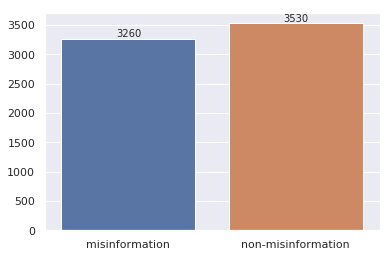

In [169]:
def print_class_balance(y):
    pos_mask = y == 1 
    pos = y[pos_mask]
    neg_mask = y == 0 
    neg = y[neg_mask]
    values = [pos.shape[0],neg.shape[0]]
    keys = ['misinformation', 'non-misinformation']
    g = sns.barplot(x = keys, y = values)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                   p.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, 5), textcoords = 'offset points')
print('data balance in dataset')        
print_class_balance(y)

# Train-test split

train
test


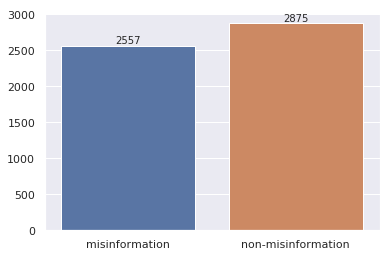

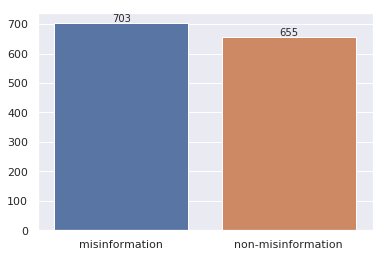

In [170]:
# use only characters
# texts = df['text']
# texts = [' '.join(list(t)) for t in texts]

# train with the 80% older messages; test with the 20% newer
# split by time

X_train_texts = texts[0:cut]
y_train= y[0:cut]
X_test_texts = texts[cut:]
y_test = y[cut:]

X_train_og_texts = original_texts[0:cut]
X_test_og_texts = original_texts[cut:]

corpus = [t.split() for t in corpus if t not in X_test_texts and type(t)==str]

print('train')
print_class_balance(y_train)
plt.figure()
print('test')
print_class_balance(y_test)

In [171]:
len(corpus)

99016

In [172]:
print('samples train')
pos_mask = y_train == 1 
mis = X_train_og_texts[pos_mask]
neg_mask = y_train == 0 
non_mis = X_train_og_texts[neg_mask]
sample = list(mis.sample(1))
print()
print('misinformation')
for m in sample:
    print('*********')
    print(m)
    print()
    
sample = list(non_mis.sample(1))
print('---------------------------------------')
print('non misinformation')
for m in sample:
    print('*********')
    print(m)
    print()

samples train

misinformation
*********
URGENTE:❗❗❗❗❗❗❗ Serviço de inteligência impede que Bolsonaro viaje para São Paulo. O candidato foi informado que ele corria risco de ser morto. Polícia Federal investiga advogados de Adélio,  que tentou matar Bolsonaro, por envolvimento com o PCC. Duas pessoas da pensão em que Adelio estava morreram após o atentado. Em video feito na noite de ontem, dia 18 de outubro, Bolsonaro lembra que Adélio  era filiado ao PSOL e esclarece aos eleitores que, de acordo com a legislação eleitoral, a partir de agora, se ele for assassinado o terceiro lugar no primeiro turno - Ciro Gomes - disputaria a eleição com Haddad.  Ontem o PDT de Ciro e o PT entraram com o pedido de impugnação da candidatura de Bolsonaro - alegando uso de Fake News - para que Haddad  e Ciro disputem a eleição. Sentindo -se ameaçado Bolsonaro foi a sede do Bope e da Polícia Federal pedir apoio. Sabendo que é impossível ganhar nas urnas as facções criminosas - inclusive o PT - querem Bolso

In [173]:
print('samples test')
pos_mask = y_test == 1 
mis = X_test_og_texts[pos_mask]
neg_mask = y_test == 0 
non_mis = X_test_og_texts[neg_mask]
sample = list(mis.sample(100))
print()
print('misinformation')
for m in sample:
    print('*********')
    print(m)
    print()
    
# sample = list(non_mis.sample(1))
# print('---------------------------------------')
# print('non misinformation')
# for m in sample:
#     print('*********')
#     print(m)
#     print()

samples test

misinformation
*********
IMPORTANTÍSSIMO!!!!   Caso o Bolsonaro nao ganhe por causa de fraude. Pegue seu comprovante de votação, e coloque  o número 17, nele contém seu número de inscrição.Tire uma foto, e envie para o Bolsonaro. Terminaremos assim com a fraude nesse país. FAREMOS ISSO! Temos que mandar rápido para todos nossos contatos. VIRALIZEM!

*********
TSE FAZENDO TESTES E AS URNAS NÃO DIGITA O NÚMERO 7 COMO AS PESSOAS DENUNCIARAM, OLHE A VERGONHA QUE ELE ESTÃO PASSANDO
Repassem 
👇

*********
O plano do falso atentado de Fernando Haddad está saindo do papel.
Compartilhar geral galera

*********
*PESQUISAS DA SEMANA*

IBOPE 57% x 43%
Datafolha 56% x 44%
Realtime 58% x 42%
CNT 57% x 43%
BTG 60% x 40%
XP 58% x 42%
Paraná 60% x 40%

*MÉDIA SIMPLES*

*Bolsonaro 58%* x 42% outro

*********
Eu sinceramente acho que a esquerda fascista está querendo tirar Bolsonaro de casa com a suposta desculpa do debate para assasina-lo, Celso Daniel que o diga. Ah, ele não pode dizer...

In [174]:
list(zip(X_test_og_texts,y_test))

[('É por isso que a Bahia deu Haddad \nBando de pilantras \nMas vai mudar !!!!',
  1),
 ('A TV Record disponibilizou esse whatsapp para qualquer irregularidade que possa ocorrer nas urnas, tirar foto/vídeos para esse número',
  1),
 ('Show da Anita ontem a noite em Imperatriz.\nTem que respeitar a vontade do povo.\nVai falar mal do MITO, toma porra!!!\n😂😂😂😂😂😂😂😂\n👊🏽👊🏽👊🏽👊🏽👊🏽👊🏽👊🏽👊🏽',
  1),
 ('Quantas cervejas devemos tomar no próximo domingo após o a confirmação da Vitória do BOLSONARO, Cabo Daciolo ?',
  0),
 ('Estudantes de Harvard e MIT são HADDAD  \n\nRepassando para os *deslikes* do Dia... \n👎👎👎\n\nhttps://youtu.be/IOoh3aUt6NU',
  1),
 ('Cid Gomes no lançamento da campanha do 2° turno de Haddad', 0),
 ('Valmir primo da silva  te convidou para assistir uma transmissão no app Mano!\n\nClique para participar: https://mano.ip.tv/s/channel/tvbolsonaro-p',
  0),
 ('Esse  é o melhor, o mais inteligente e o mais esclarecedor dos vídeos,  e feito por uma criança 😳👏🏻👏🏻👏🏻',
  0),
 ('Gente, escu

# BoW

In [175]:
#vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
vectorizer = CountVectorizer(max_features = None, ngram_range = (1,3), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)
vectorizer.fit(X_train_texts)   
X_train = vectorizer.transform(X_train_texts)
X_test = vectorizer.transform(X_test_texts)
X_train.shape

(5432, 329395)

In [176]:
print(vectorizer.get_feature_names()[100:150])

['! ! entrar', '! ! errar', '! ! escolher', '! ! esculachou', '! ! escutar', '! ! espalhar', '! ! esperanca', '! ! esperar', '! ! estao', '! ! estar', '! ! evitar', '! ! exigir', '! ! facam', '! ! falir', '! ! familia', '! ! faomos', '! ! farar', '! ! farlei', '! ! fato', '! ! favor', '! ! faxinar', '! ! fazer', '! ! feliz', '! ! fernando', '! ! ficar', '! ! ficor', '! ! filhar', '! ! fiscal', '! ! focar', '! ! foraaaaaa', '! ! forcar', '! ! fraudar', '! ! froudor', '! ! futurar', '! ! gang', '! ! ganhar', '! ! general', '! ! gente', '! ! gloriar', '! ! golpe', '! ! goo', '! ! gracas', '! ! grande', '! ! grupar', '! ! haddad', '! ! hanna', '! ! hoje', '! ! homem', '! ! homenagem', '! ! incluir']


logistic regression + binary bow
0.42
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       655
           1       0.85      0.79      0.82       703

    accuracy                           0.82      1358
   macro avg       0.82      0.82      0.82      1358
weighted avg       0.82      0.82      0.82      1358

AUC:  0.8940158318221798


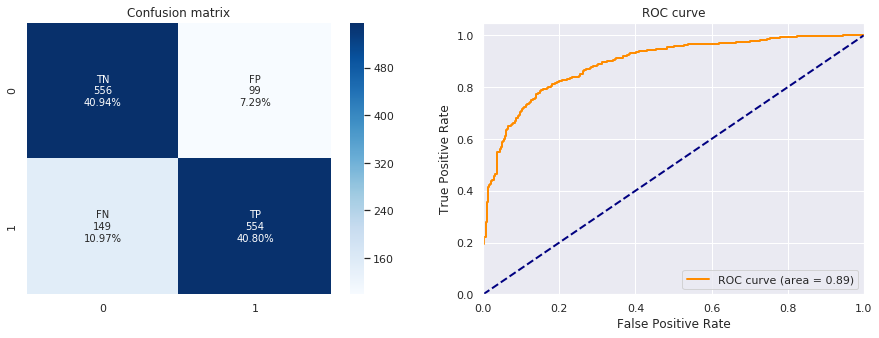

(0.8173784977908689,
 0.8483920367534457,
 0.8176470588235295,
 0.7880512091038406,
 0.8176470588235295,
 0.8171091445427728,
 0.8176470588235295,
 0.8940158318221798)

In [177]:
print('logistic regression + binary bow')
clf = LogisticRegression()
clf.fit(X_train,y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

#thr = optimal_threshold(y_prob,y_test)
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + bow
Iteration 1, loss = 0.61184277
Validation score: 0.702206
Iteration 2, loss = 0.42190716
Validation score: 0.795956
Iteration 3, loss = 0.31657775
Validation score: 0.821691
Iteration 4, loss = 0.25139279
Validation score: 0.836397
Iteration 5, loss = 0.20658913
Validation score: 0.845588
Iteration 6, loss = 0.17281358
Validation score: 0.852941
Iteration 7, loss = 0.14736434
Validation score: 0.854779
Iteration 8, loss = 0.12697479
Validation score: 0.856618
Iteration 9, loss = 0.11105877
Validation score: 0.860294
Iteration 10, loss = 0.09694797
Validation score: 0.865809
Iteration 11, loss = 0.08527977
Validation score: 0.862132
Iteration 12, loss = 0.07600489
Validation score: 0.863971
Iteration 13, loss = 0.06817369
Validation score: 0.865809
Iteration 14, loss = 0.06102467
Validation score: 0.865809
Validation score did not improve more than tol=0.001000 for 3 consecutive epochs. Stopping.
0.54
              precision    recall  f1-score   support

           0       0.

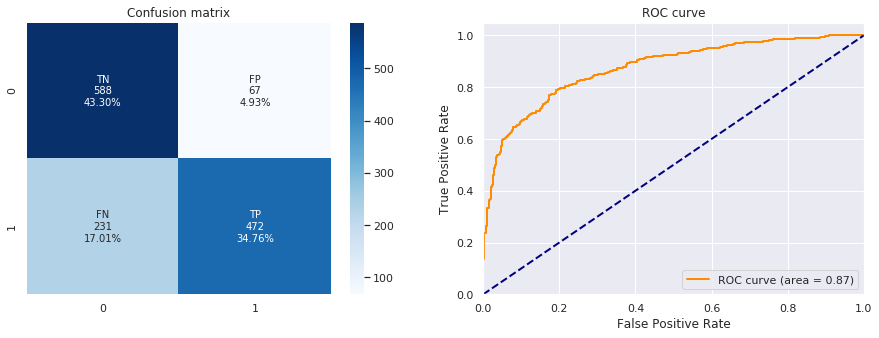

(0.780559646539028,
 0.87569573283859,
 0.7978290366350069,
 0.6714082503556188,
 0.7978290366350069,
 0.7600644122383254,
 0.7978290366350069,
 0.8728893618407481)

In [132]:
print('mlp + bow')
clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-3, verbose = True, early_stopping = True, 
                   n_iter_no_change = 3, max_iter = 20,
                   hidden_layer_sizes = (100,), alpha = .0001, 
                   learning_rate_init = .0001, batch_size = 200)

clf.fit(X_train,y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Topic modelling (LDA)

In [133]:
# # topics
# from gensim.models import LdaModel
# from gensim.corpora.dictionary import Dictionary
# n_topics = 15

# def train_lda(corpus, n_topics = 100):
#     common_texts = [x.split() for x in corpus]
#     common_dictionary = Dictionary(common_texts)
#     common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
#     lda = LdaModel(common_corpus, num_topics=n_topics)
#     return lda, common_dictionary

# lda, common_dictionary = train_lda(X_train_texts, n_topics)

In [134]:
# # vectorizing
# def tup2array(tuples,n_topics):
#     topics = np.zeros(n_topics)
#     for t, p in tuples:
#         topics[t] = p
#     return topics

# def vectorize_topics(X,lda):
#     X = [lda[x] for x in X]
#     X = [tup2array(v,lda.num_topics) for v in X]
#     return X

# def texts2topics(texts,lda):
#     X = [x.split() for x in texts]
#     X = [common_dictionary.doc2bow(text) for text in X]
#     X = vectorize_topics(X,lda)
#     return X
    

# X_train_topics = texts2topics(X_train_texts,lda)
# X_test_topics = texts2topics(X_test_texts,lda)

In [135]:
# print('logistic regression + lda')
# clf = LogisticRegression()
# clf.fit(X_train_topics,y_train)
# y_prob = clf.predict_proba(X_test_topics)[:,1]
# y_prob_train = clf.predict_proba(X_train_topics)[:,1]
# thr = optimal_threshold(y_prob_train,y_train)
# print(thr)
# y_pred = [1 if p >= thr else 0 for p in y_prob]
# test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

In [136]:
# print('mlp + lda')
# # clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
# #                    tol = 1e-3, verbose = True, early_stopping = True, 
# #                    n_iter_no_change = 3, max_iter = 100,
# #                    hidden_layer_sizes = (100,), alpha = .00001, 
# #                    learning_rate_init = .0001, batch_size = 32)
# # hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# # clf = optimized_mlp(hl,bs,al,lri)

# # results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)
# clf.fit(X_train_topics,y_train)
# y_prob = clf.predict_proba(X_test_topics)[:,1]
# y_prob_train = clf.predict_proba(X_train_topics)[:,1]
# thr = optimal_threshold(y_prob_train,y_train)
# print(thr)
# y_pred = [1 if p >= thr else 0 for p in y_prob]
# test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Word embeddings

In [137]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

In [138]:
len(corpus)

99016

In [139]:
class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training"""

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        self.epoch += 1
        print("W2V: Epoch #{}".format(self.epoch))
        
epoch_logger = EpochLogger()

w2v = Word2Vec(min_count=1)
w2v.build_vocab(corpus)  # prepare the model vocabulary
w2v.train(corpus, total_examples=w2v.corpus_count, 
            epochs=15, compute_loss=True, 
            callbacks=[epoch_logger])

w2v.save("data/2018/word2vec_train.model")

w2v = Word2Vec.load("data/2018/word2vec_train.model")

W2V: Epoch #1
W2V: Epoch #2
W2V: Epoch #3
W2V: Epoch #4
W2V: Epoch #5
W2V: Epoch #6
W2V: Epoch #7
W2V: Epoch #8
W2V: Epoch #9
W2V: Epoch #10
W2V: Epoch #11
W2V: Epoch #12
W2V: Epoch #13
W2V: Epoch #14
W2V: Epoch #15


In [140]:
w2v.most_similar(positive=['deus'])

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('dars', 0.7146254181861877),
 ('vosso', 0.6393389105796814),
 ('senhor', 0.6037132143974304),
 ('cristo', 0.5999789834022522),
 ('orar', 0.5988916754722595),
 ('ceus', 0.5961741209030151),
 ('oracao', 0.589393138885498),
 ('paz', 0.5810234546661377),
 ('ti', 0.580318808555603),
 ('coracao', 0.5780038237571716)]

In [141]:
def vectorize_text(model, text, method='mean'):
        """
        Convert all words in a text to their embedding vector
        and calculate a vector for the text, by the mean or the sum of word vectors
        Parameters
        ----------
        text: str
        Text from wich the word vector's will be calculated    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        vec: numpy.ndarray 
        Array of the word embeddings from the given text 
        """
        n = model.vector_size
        X = np.empty(shape=[0, n])
        words = text.split()
        for word in words:
            try:
                vec = model[word]
                X = np.append(X,[vec], axis = 0)
            # if oov:    
            except:
                #print('word not in vocabulary: ', word)
                continue
        if X.size == 0:
            vec = np.zeros(n)
        elif method == 'mean':
            vec = np.mean(X,axis=0)
        elif method == 'sum':
            vec = np.sum(X,axis=0)
        return vec
    
def vectorize_corpus(model, corpus, method='mean'):
        """
        Convert all texts in a corpus to vectors
        Parameters
        ----------
        corpus: list
        List of texts    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        X: numpy.ndarray 
        2D Array of vectors from each text in corpus
        """
        X = [vectorize_text(model, text, method=method) for text in corpus]
        X = np.concatenate(X, axis=0).reshape(len(X),len(X[0]))
        return X

x = vectorize_corpus(w2v, 'bolsonaro é um prego')
x

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


array([[ 0.76043952,  0.88879251, -0.90697527, ...,  2.15013814,
         0.7196781 ,  0.28560203],
       [ 3.00207233, -4.6533699 , -0.19180547, ..., -0.1885826 ,
        -1.59377575,  0.92375523],
       [-0.58913201,  0.45220304,  0.12042369, ...,  2.04464436,
         0.13235311, -0.52890253],
       ...,
       [-0.42522535, -0.17314038, -0.21733224, ...,  0.18411075,
         0.0935633 , -0.13170595],
       [-0.26353815,  0.03204688, -0.65704316, ..., -0.42762509,
        -1.10094047, -0.71728772],
       [ 3.00207233, -4.6533699 , -0.19180547, ..., -0.1885826 ,
        -1.59377575,  0.92375523]])

In [142]:
X_train = vectorize_corpus(w2v,X_train_texts)
X_test = vectorize_corpus(w2v,X_test_texts)

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


logistic regression + w2v
0.46
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       655
           1       0.69      0.72      0.70       703

    accuracy                           0.68      1358
   macro avg       0.68      0.68      0.68      1358
weighted avg       0.68      0.68      0.68      1358

AUC:  0.7441738242863192


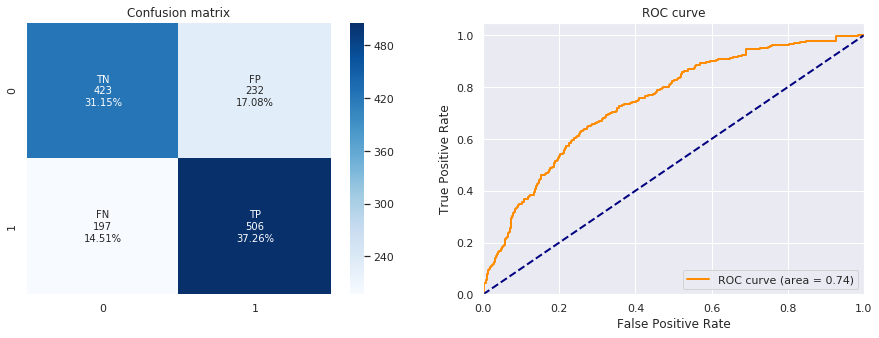

In [143]:
print('logistic regression + w2v')
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + w2v
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
AUC: 0.877
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
AUC: 0.885
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
AUC: 0.878
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
AUC: 0.911
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
AUC: 0.886
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
AUC: 0.874
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
AUC: 0.897
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
AUC: 0.892
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
AUC: 0.877
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
AUC: 0.887
10 
hidden layers: (75, 300, 25); alpha: 0.00002; learning rate: 0.0012

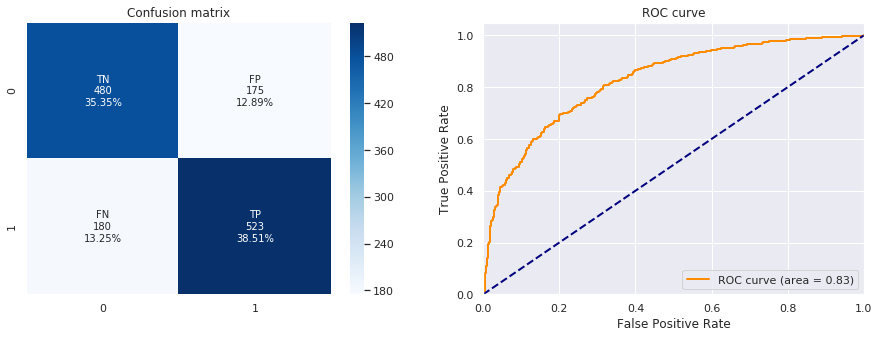

In [144]:
print('mlp + w2v')
# clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-3, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 100,
#                    hidden_layer_sizes = (100,), alpha = .00001, 
#                    learning_rate_init = .0001, batch_size = 32)
# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)

# results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter=20)
clf = optimized_mlp(hl,bs,al,lri)
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Doc2Vec

In [145]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)
model.save('data/2018/doc2vec.model')

doc2vec = Word2Vec.load("data/2018/doc2vec.model")

In [146]:
doc2vec.infer_vector(['bolsonaro','meu','ovo'])

array([-6.6602312e-02, -3.4949172e-02, -4.9710464e-02, -4.2498123e-02,
       -1.2360432e-02,  1.3445731e-02,  6.4053880e-03, -2.5431946e-02,
       -1.3398189e-02,  3.2861233e-02,  1.9098092e-02, -2.7876189e-02,
        6.3099982e-03, -3.1566672e-02, -3.1930435e-02, -1.0488373e-02,
       -4.1927681e-03,  1.5584757e-02, -7.0700116e-05, -3.9354652e-02,
       -1.0245880e-02,  1.4009416e-02,  4.0548917e-02,  3.9947737e-02,
        8.7503903e-03, -2.1188991e-02, -5.8014154e-02,  1.2945187e-03,
       -8.7645007e-03,  2.9913289e-03,  1.0643284e-02,  2.2884613e-02,
       -1.0495075e-02,  6.5721613e-03,  3.7700005e-02, -4.1312732e-02,
       -1.1737006e-02,  3.6062714e-02,  4.1949291e-02, -5.9720329e-03,
       -3.1339686e-04,  1.1771470e-02, -1.9825641e-02, -3.3737447e-02,
       -3.6152098e-02,  5.4852455e-03, -1.1186537e-02, -4.1857189e-03,
        1.6273582e-02,  2.3028158e-02, -3.7187722e-02,  1.7717843e-03,
        9.8573705e-03, -1.4747194e-03, -1.8118804e-02, -9.9917008e-03,
      

In [147]:
def vectorize_doc2vec(model,text):
    text = text.split()
    vector = model.infer_vector(text)
    return vector

def vectorize_corpus_doc2vec(model,corpus):
    X = [vectorize_doc2vec(model, text) for text in corpus]
    X = np.concatenate(X, axis=0).reshape(len(X),len(X[0]))
    return X

X_train = vectorize_corpus_doc2vec(doc2vec, X_train_texts)
X_test = vectorize_corpus_doc2vec(doc2vec, X_test_texts)

logistic regression + doc2vec
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       655
           1       0.68      0.62      0.65       703

    accuracy                           0.65      1358
   macro avg       0.65      0.65      0.65      1358
weighted avg       0.65      0.65      0.65      1358

AUC:  0.7228323542505946


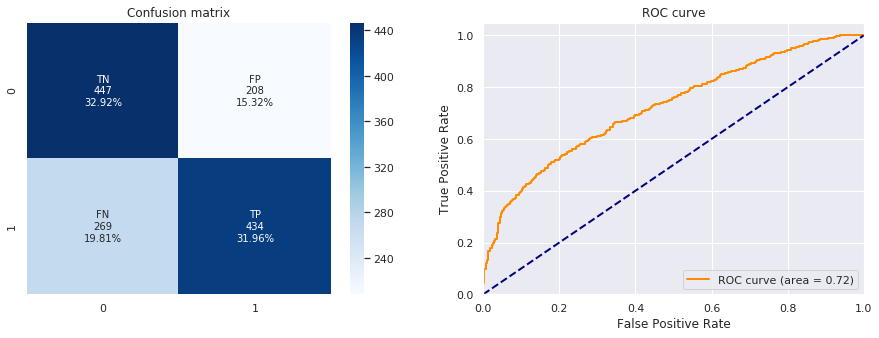

(0.6487481590574374,
 0.67601246105919,
 0.6520787746170679,
 0.6173541963015647,
 0.6520787746170679,
 0.645353159851301,
 0.6520787746170679,
 0.7228323542505946)

In [148]:
print('logistic regression + doc2vec')
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + doc2vec
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
AUC: 0.865
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
AUC: 0.848
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
AUC: 0.864
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
AUC: 0.884
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
AUC: 0.859
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
AUC: 0.837
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
AUC: 0.873
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
AUC: 0.869
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
AUC: 0.869
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
AUC: 0.863
10 
hidden layers: (75, 300, 25); alpha: 0.00002; learning rate: 0.

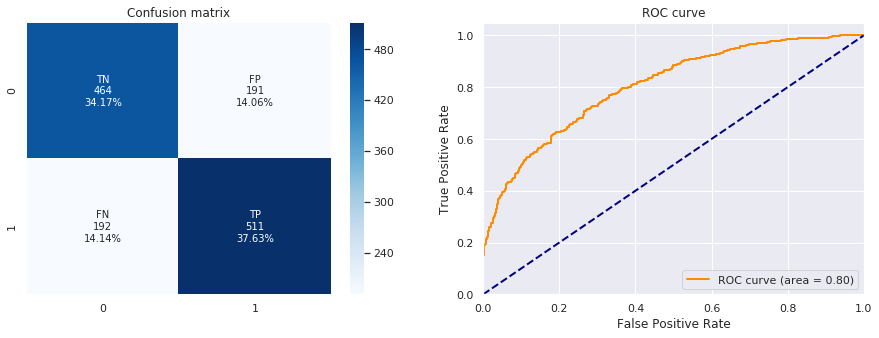

In [149]:
print('mlp + doc2vec')
# clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-3, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 100,
#                    hidden_layer_sizes = (100,), alpha = .00001, 
#                    learning_rate_init = .0001, batch_size = 32)
# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)

# results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter=50)
clf = optimized_mlp(hl,bs,al,lri)
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)